# Jester Collaborative Filtering Recommendation Engine

Prepared by: Darwin

Instructor: Forward School

##### Abstract
This assignment is to performing a collaborative filtering on the Jester Dataset with the dimensions of ***7699 by 159 matrix*** and building a recommendation engine for recommending the next *jokes*

(http://eigentaste.berkeley.edu/dataset/).

## Part 1: Data Understanding
**Over 100,000 new ratings from 7,699 total users: data collected from April 2015 - Nov 2019** </br>
The text of the jokes: Dataset4JokeSet.xlsx (31 KB)

Format:
1. An excel sheet with 158 rows.
2. The row number corresponds to the joke ID referred to in the Excel files below

The Ratings Data: Jester_Rating.xlsx (3 MB)

Format:

* The data is formatted as an excel file representing a ***7699 by 159 matrix*** with rows as users and columns as jokes. The left-most column represents the amount of jokes rated by each user. There are a total of 7699 users and 158 jokes in this dataset.
* Each rating is from (-10.00 to +10.00) and 99 corresponds to a null rating (user did not rate that joke).

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_excel)

import matplotlib.pyplot as plt #visualization
%matplotlib inline

In [2]:
# surprise library

# For building the dataset (sparse matrix) & ratings
from surprise import Dataset, Reader

# For run cross-validation or split and search the best parameters for a prediction algorithm
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate, KFold

# Similarities components, To compute similarity metrics between users or items
from surprise.similarities import cosine, msd, pearson, pearson_baseline

# k-NN inspired algorithms, *Memory-based Collaborative Filtering*
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore

# Matrix Factorization-based algorithms, *Model-based Collaborative Filtering*
from surprise import SVD, SVDpp

# Others Models from Surprise Library, also a *Model-based Collaborative Filtering*
from surprise import SlopeOne, CoClustering

# to compare result of each models
from surprise import accuracy

In [3]:
# Import jokes text
df_jokes = pd.read_excel('Data/Dataset4JokeSet.xlsx', header=None, names = ['jokes'])

# Shift the index by 1, and add a prefix for easier representations & visualization
df_jokes.set_index('jokes_' + (df_jokes.index + 1).astype(str), inplace = True )

display(df_jokes)
print(df_jokes['jokes']['jokes_82'])

,jokes
jokes_1,"A man visits the doctor. The doctor says ""I ha..."
jokes_2,This couple had an excellent relationship goin...
jokes_3,Q. What's 200 feet long and has 4 teeth? A. ...
jokes_4,Q. What's the difference between a man and a t...
jokes_5,Q.\tWhat's O. J. Simpson's Internet address? ...
...,...
jokes_154,"Poodle: ""My life is a mess. My owner is mean, ..."
jokes_155,Did you hear that NASA has launched several co...
jokes_156,"A bear walks into a bar and says,""I'd like a b..."
jokes_157,A dog goes into a bar and orders a martini. Th...


Q: How do you keep a computer programmer in the  shower all day long?  A: Give them a shampoo with a label that says "rinse, lather, repeat".


In [4]:
## import 7699 by 159 matrix ratings
df_ratings = pd.read_excel('Data/Jester_Rating.xlsx', header=None)
display(df_ratings)

,0,1,2,3,4,5,6,7,8,9,...,149,150,151,152,153,154,155,156,157,158
0,1.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.00,99.00,99.00,99.00,99.00,99.0,99.00,99.00,99.00,99.00
1,1.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.00,99.00,99.00,99.00,99.00,99.0,99.00,99.00,99.00,99.00
2,4.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.00,99.00,99.00,99.00,99.00,99.0,99.00,99.00,99.00,99.00
3,47.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.00,99.00,5.61,-4.51,0.00,0.0,99.00,0.00,5.93,4.19
4,13.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.00,99.00,99.00,99.00,99.00,0.0,99.00,99.00,99.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7694,27.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,0.00,99.00,0.00,0.00,0.00,99.0,0.00,0.00,0.00,99.00
7695,1.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.00,99.00,99.00,99.00,99.00,99.0,99.00,99.00,99.00,99.00
7696,26.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.00,8.63,99.00,6.76,0.00,3.5,6.26,99.00,-2.66,0.65
7697,64.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,2.03,99.00,2.05,2.05,0.73,0.0,2.97,0.57,0.00,0.00


### 1.1: Describe Data

* There are 158 columns (represent each 158 jokes) inside the dataset, and all of the datatype are **float**.
* Each rating is from (-10.00 to +10.00)
* 99 corresponds to a null rating (user did not rate that joke)
* Since Recommendation Engine is a unsupervised learning, there are no Y variables here

## Part 2: Data Manipulation

In [5]:
# Original memory usage
before  = df_ratings.memory_usage().sum() / 1024 / 1024

# removing 1st columns since it only represents the amount of jokes rated by each user
df_ratings.drop(0, axis = 1, inplace = True)

# rename columns so that it was similar to df_jokes
df_ratings = df_ratings.add_prefix('jokes_')

#Replacing 99 with actual numpy null values
df_ratings.replace(99.0, np.nan, inplace = True)

# drop entire column if the entire column is null (no ratings from any users)
null_ratings = df_ratings.columns[df_ratings.isnull().all()]
df_ratings.dropna(how='all', axis=1, inplace = True)

# convert dtypes to float32 for faster processing
df_ratings = df_ratings.astype(np.float32) 
after = df_ratings.memory_usage().sum() / 1024 / 1024
print ("\n Memory Size before datatype conversion & manipulation: %.2f MB" %(before))
print ("\n Memory Size after  datatype conversion & manipulation: %.2f MB" %(after))

print ("\n\n\n Jokes without any ratings : " ,null_ratings)
display(df_ratings)

Jokes without any ratings :  Index(['jokes_1', 'jokes_2', 'jokes_3', 'jokes_4', 'jokes_5', 'jokes_6',
       'jokes_9', 'jokes_10', 'jokes_11', 'jokes_12', 'jokes_14', 'jokes_20',
       'jokes_27', 'jokes_31', 'jokes_43', 'jokes_51', 'jokes_52', 'jokes_61',
       'jokes_73', 'jokes_80', 'jokes_100', 'jokes_116'],
      dtype='object')
Memory Size before datatype conversion & manipulation: 9.34 MB
Memory Size after  datatype conversion & manipulation: 3.99 MB


,jokes_7,jokes_8,jokes_13,jokes_15,jokes_16,jokes_17,jokes_18,jokes_19,jokes_21,jokes_22,...,jokes_149,jokes_150,jokes_151,jokes_152,jokes_153,jokes_154,jokes_155,jokes_156,jokes_157,jokes_158
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.98,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.41,-4.59,NaN,...,NaN,NaN,5.61,-4.51,0.00,0.0,NaN,0.00,5.93,4.19
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.72,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,...,0.00,NaN,0.00,0.00,0.00,NaN,0.00,0.00,0.00,NaN
7695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.51,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.93,NaN,NaN,...,NaN,8.63,NaN,6.76,0.00,3.5,6.26,NaN,-2.66,0.65
7697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.52,5.37,NaN,...,2.03,NaN,2.05,2.05,0.73,0.0,2.97,0.57,0.00,0.00


> 22 of the jokes don't have ratings, their ids are: {1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 14, 20, 27, 31, 43, 51, 52, 61, 73, 80, 100, 116}.

In [6]:
df_stack = df_ratings.stack().reset_index()
df_stack.columns = ['userId', 'jokesId', 'rating']
df_stack

,userId,jokesId,rating
0,0,jokes_72,3.70
1,1,jokes_72,8.21
2,2,jokes_19,-5.98
3,2,jokes_35,-4.47
4,2,jokes_72,1.59
...,...,...,...
106484,7697,jokes_156,0.57
106485,7697,jokes_157,0.00
106486,7697,jokes_158,0.00
106487,7698,jokes_19,4.59


# Part 3: Data Preparation

Within the group of collaborative filtering, the two most well-known distinct approaches are:

* `Memory-based models`, which calculate the similarities between users / items based on user-item rating pairs.
    > Example : `K-Neareast Neighbors` of the **item-item** ratings matrix

* `Model-based models`, which use some sort of machine learning algorithm to estimate the ratings. 
    > Example : `Singular Value Decomposition` of the **user-item** ratings matrix.

In [13]:
# Creating a Suprise Reader with rating_scale as a tuple of lowest and highest possible range
reader = Reader(rating_scale = (-10.0, 10.0))

# Convert data into a sparse matrix where individual ratings are elements in this matrix
data = Dataset.load_from_df(df_stack[['userId', 'jokesId', 'rating']], reader)

Number of users  :  7407 

Number of items  :  136 

Number of ratings:  85191 

Rating Scale:  (-10.0, 10.0) 

Global Mean :  0.5022379127729938 

Length of Testset :  21298 



In [16]:
# splitting the data into trainset and testset, test_size is set to 20%:
trainset, testset = train_test_split(data, test_size=0.20, random_state = 42)

print('Number of users  : ', trainset.n_users, '\n')
print('Number of items  : ', trainset.n_items, '\n')
print('Number of ratings: ', trainset.n_ratings, '\n')
print('Rating Scale: ', trainset.rating_scale, '\n')
print('Global Mean : ', trainset.global_mean, '\n\n')
print('Length of Testset : ', len(testset), '\n\n\n\n')

# Convert an item inner id to a raw id, 
trainset_iids = list(trainset.all_items())
iid_converter = lambda x: trainset.to_raw_iid(x)
trainset_raw_iids = list(map(iid_converter, trainset_iids))

print('Example of inner id  : ', trainset_iids[:5], '\n')
print('Example of raw id    : ', trainset_raw_iids[:5], '\n')

Number of users  :  7407 

Number of items  :  136 

Number of ratings:  85191 

Rating Scale:  (-10.0, 10.0) 

Global Mean :  0.5022379127729938 


Length of Testset :  21298 




Example of inner id  :  [0, 1, 2, 3, 4] 

Example of raw id    :  ['jokes_72', 'jokes_117', 'jokes_107', 'jokes_19', 'jokes_77'] 



In layman terms, On trainset creation, each raw id is mapped to a unique integer called inner id
* Raw iid is the actual index named in the original file
* Inner iid is the index created during trainset creation

In [17]:
# we are using the trainsetfull to save distance metrics
trainsetfull = data.build_full_trainset()
print('Number of users: ', trainsetfull.n_users, '\n')
print('Number of items: ', trainsetfull.n_items, '\n')

trainsetfull_iids = list(trainsetfull.all_items())
iid_converter = lambda x: trainsetfull.to_raw_iid(x)
trainsetfull_raw_iids = list(map(iid_converter, trainsetfull_iids))

Number of users:  7699 

Number of items:  136 



# Part 4: Modelling

## 4.1: Memory-based models Collaborative Filtering

### 4.1.1: `k-NN inspired algorithms` - kNN Models without Baseline

First, we define the similarity options, to be used by different models. The four options are:
- `msd`
- `cosine`
- `pearson`
- `pearson_baseline`

In [18]:
sim_msd = {'name':'MSD', 'user_based':False}
sim_cos = {'name':'cosine', 'user_based':False}
sim_pearson = {'name':'pearson', 'user_based':False}
sim_pearson_baseline = {'name': 'pearson_baseline','user_based':False, 'shrinkage': 100}

sim_options = [sim_msd, sim_cos, sim_pearson, sim_pearson_baseline]

In [19]:
# number of neighbors
list_of_ks = [10,20,40]

# empty list to store kNN scores
kNN_scores = []

On to the modelling. 

`KNNBasic`, `KNNWithMean`, `KNNWithZScore` can be used with first three sims, to tune: `k`, number of neighbors, looking at these first. 

Starting with the three `kNN` models that have no baseline attached to them. We are using `cross_validate` on all of them, and then save the results

Then, we pick the best performing model, and train it on the trainset only. 

In [29]:
# KNNBasic
for curr_sim_option in sim_options[0:3]:

    for curr_k in list_of_ks:
        
        print(
            'Currently calculating sim_option = ' + str(curr_sim_option['name']) + \
            ' and k = ' + str(curr_k) + ' ...' )        
        algo = KNNBasic(k = curr_k, sim_options = curr_sim_option)
        results = cross_validate(algo, data, measures=['RMSE'], cv=3, return_train_measures=True);
        
        kNN_scores.append(['KNNBasic', curr_sim_option['name'], str(curr_k), 
                        str(np.mean(results['train_rmse'])), str(np.mean(results['test_rmse']))]
                      )

Currently calculating sim_option = MSD and k = 10 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Currently calculating sim_option = MSD and k = 20 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Currently calculating sim_option = MSD and k = 40 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Currently calculating sim_option = cosine and k = 10 ...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done c

In [30]:
# KNNWithMeans
for curr_sim_option in sim_options[0:3]:

    for curr_k in list_of_ks:
        
        print(
            'Currently calculating sim_option = ' + str(curr_sim_option['name']) + \
            ' and k = ' + str(curr_k) + ' ...' )
        algo = KNNWithMeans(k = curr_k, sim_options = curr_sim_option)
        results = cross_validate(algo, data, measures=['RMSE'], cv=3, return_train_measures=True);
        
        kNN_scores.append(['KNNWithMeans', curr_sim_option['name'], str(curr_k), 
                        str(np.mean(results['train_rmse'])), str(np.mean(results['test_rmse']))]
                      )
            

Currently calculating sim_option = MSD and k = 10 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Currently calculating sim_option = MSD and k = 20 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Currently calculating sim_option = MSD and k = 40 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Currently calculating sim_option = cosine and k = 10 ...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done c

In [31]:
# KNNWithZScore
for curr_sim_option in sim_options[0:3]:

    for curr_k in list_of_ks:
        
        print(
            'Currently calculating sim_option = ' + str(curr_sim_option['name']) + \
            ' and k = ' + str(curr_k) + ' ...' )
        algo = KNNWithZScore(k = curr_k, sim_options = curr_sim_option)
        results = cross_validate(algo, data, measures=['RMSE'], cv=3, return_train_measures=True);

        kNN_scores.append(['KNNWithZScore', curr_sim_option['name'], str(curr_k), 
                        str(np.mean(results['train_rmse'])), str(np.mean(results['test_rmse']))]
                      )

Currently calculating sim_option = MSD and k = 10 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Currently calculating sim_option = MSD and k = 20 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Currently calculating sim_option = MSD and k = 40 ...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Currently calculating sim_option = cosine and k = 10 ...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done c

In [34]:
# store result to dataframe and sort by test root mean square error by ascending order (smaller rmse = smaller error)
df_kNN = pd.DataFrame(kNN_scores, columns = ['model_type', 'similarity_option', 'k', 'train_rmse', 'test_rmse'])
df_kNN.sort_values(by = 'test_rmse', inplace = True)
df_kNN

,model_type,similarity_option,k,train_rmse,test_rmse
17,KNNWithMeans,pearson,40,3.2531799491999114,4.573265990871269
13,KNNWithMeans,cosine,20,3.159682964715261,4.5799248468706075
14,KNNWithMeans,cosine,40,3.2903850378669244,4.583245241152444
16,KNNWithMeans,pearson,20,3.1003618713234586,4.5905238569670885
10,KNNWithMeans,MSD,20,1.3359292867425185,4.5925886023067655
11,KNNWithMeans,MSD,40,1.6799542931536193,4.595086217615626
23,KNNWithZScore,cosine,40,3.296224688519716,4.5953194284848875
20,KNNWithZScore,MSD,40,1.6825021258480246,4.5994594505434705
26,KNNWithZScore,pearson,40,3.2576625023139862,4.600459390823622
22,KNNWithZScore,cosine,20,3.1618570717831602,4.601089923272977


Based on the results, best model seems to be this: 
- model type: `kNNWithMeans` 
- similarity option: `pearson` 
- `k`: 40
<br>

Overall, `pearson` seems to be a good similarity option. `kNNwithMeans` and `kNNWithZScore` outperforms `kNNBasic`.

There is probably some overfitting, the train scores are much lower than the test scores (which is what you want, a low `rmse` score), but there is not much that can be done with it. The `cross_validated` test scores are quite promising. 

### 4.1.2: Chosen Model Fitting for Memory Based Collaborative Filtering

Rather than performing on k-fold (cross-validation), we will now train the data by using pre-split train & test data (real-world scenario)

In [76]:
# based on above performance results
chosen_k = 40
chosen_sim_option = sim_pearson

chosen_knn = KNNWithMeans(k = chosen_k, sim_options = chosen_sim_option)
chosen_knn.fit(trainset)

predictions_knn = chosen_knn.test(testset)
accuracy_knn = accuracy.rmse(predictions_knn)
print(accuracy_knn)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 4.5426
4.5426344688433415


`rmse` score for the chosen kNN without baseline model is __4.5426__. 

## 4.2: Model-based models Collaborative Filtering

### 4.2.1: `Matrix Factorization-based algorithms` - SVD (Singular value decomposition)

First, we need to fine tune the hyperparameter by trial and error, the process can be made easier by utilizing GridSearchCV:
- `n_factors` : The number of factors. Default is 100.
- `n_epochs`  : The number of iteration of the SGD procedure. Default is 20.
- `lr_all`    : The learning rate for all parameters. Default is 0.005.
- `reg_all`   : The regularization term for all parameters. Default is 0.02.

In [46]:
# randomly set hyperparameter
param_grid_1 = {'n_factors':[50, 100, 150], 'n_epochs': [10, 20, 30], 
                'lr_all': [0.002, 0.005, 0.008], 'reg_all': [0.01, 0.02, 0.03]}

gs_model_1 = GridSearchCV(SVD, param_grid = param_grid_1, n_jobs = -1, joblib_verbose = 5)
gs_model_1.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  4.1min finished


In [47]:
gs_model_1.best_score

{'rmse': 4.466144549910821, 'mae': 3.361722795181818}

In [48]:
gs_model_1.best_params

{'rmse': {'n_factors': 150, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.03},
 'mae': {'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.03}}

Intepretations & thoughts process
- Since `n_factors` show better result at **higher** range `100`, we will try compare with `200`
- Since `n_epochs` show better result at **lower** range `10`, we will try compare with `5`
- Since `lr_all` show better result at **lower** range `0.002`, we will try compare with `0.001`
- Since `reg_all` show better result at **higher** range `0.03`, we will try compare with `0.04 & 0.05`

In [49]:
# set hyperparameter based on above best_params. to find 'better' parameter
param_grid_2 = {'n_factors':[150, 200], 'n_epochs': [5, 10], 
                'lr_all': [0.001, 0.002], 'reg_all': [0.03, 0.04, 0.05]}

gs_model_2 = GridSearchCV(SVD, param_grid = param_grid_2, n_jobs = -1, joblib_verbose = 5)
gs_model_2.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 114 out of 120 | elapsed:   44.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   44.7s finished


In [50]:
gs_model_2.best_score

{'rmse': 4.453403248090696, 'mae': 3.3533491795436654}

In [51]:
gs_model_2.best_params

{'rmse': {'n_factors': 200, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.05},
 'mae': {'n_factors': 200, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.05}}

Intepretations & thoughts process
- Since `n_factors` show better result at **higher** range `200`, we will try compare with `300 & 400`
- Since `n_epochs` doesn't show better result, we will stop tuning it and set as `10`
- Since `lr_all` doesn't show better result, we will stop tuning it and set as `0.002`
- Since `reg_all` show better result at **higher** range `0.05`, we will try compare with `0.10 & 0.15`

In [52]:
param_grid_3 = {'n_factors':[200, 300, 400], 'n_epochs': [10], 
                'lr_all': [0.002], 'reg_all': [0.05, 0.10, 0.15]}

gs_model_3 = GridSearchCV(SVD, param_grid = param_grid_3, n_jobs = -1, joblib_verbose = 5)
gs_model_3.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  45 | elapsed:   24.2s remaining:   21.2s
[Parallel(n_jobs=-1)]: Done  34 out of  45 | elapsed:   42.0s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   43.1s finished


In [53]:
gs_model_3.best_score

{'rmse': 4.4343113079349195, 'mae': 3.340715639244651}

In [54]:
gs_model_3.best_params

{'rmse': {'n_factors': 300, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.1},
 'mae': {'n_factors': 300, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.1}}

Intepretations & thoughts process
- Since `n_factors` show better result at **middle** range `300`, we will try compare with `250 & 350`
- Since `n_epochs` doesn't show better result, we will stop tuning it and set as `10`
- Since `lr_all` doesn't show better result, we will stop tuning it and set as `0.002`
- Since `reg_all` show better result at **middle** range `0.1`, we will try compare with `0.08 & 0.12`

In [55]:
param_grid_4 = {'n_factors':[250, 300, 350], 'n_epochs': [10], 
                'lr_all': [0.002], 'reg_all': [0.08, 0.10, 0.12]}

gs_model_4 = GridSearchCV(SVD, param_grid = param_grid_4, n_jobs = -1, joblib_verbose = 5)
gs_model_4.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  45 | elapsed:   24.1s remaining:   21.1s
[Parallel(n_jobs=-1)]: Done  34 out of  45 | elapsed:   38.5s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   39.4s finished


In [56]:
gs_model_4.best_score

{'rmse': 4.431495567615721, 'mae': 3.337983586097452}

In [57]:
gs_model_4.best_params

{'rmse': {'n_factors': 300, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.1},
 'mae': {'n_factors': 300, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.1}}

Intepretations & thoughts process
- Since `n_factors` doesn't show better result, we will stop tuning it and set as `300`
- Since `n_epochs` doesn't show better result, we will stop tuning it and set as `10`
- Since `lr_all` doesn't show better result, we will stop tuning it and set as `0.002`
- Since `reg_all` doesn't show better result, we will stop tuning it and set as `0.1`

We will stop exploring apply the hyperparameter on trainset & testset

In [75]:
chosen_SVD = SVD(n_factors= 300, n_epochs=10, lr_all=0.002, reg_all=0.1)
chosen_SVD.fit(trainset)
predictions_SVD = chosen_SVD.test(testset)
accuracy_SVD = accuracy.rmse(predictions_SVD)
print(accuracy_SVD)

RMSE: 4.4368
4.436752521505912


`rmse` score for the chosen SVD model is __4.4368__.

### 4.2.2: `Matrix Factorization-based algorithms` - SVD++

The SVD++ algorithm, an extension of SVD taking into account implicit ratings. </br>

First, we need to fine tune the hyperparameter by trial and error, the process can be made easier by utilizing GridSearchCV:
- `n_factors` : The number of factors. Default is 20.
- `n_epochs`  : The number of iteration of the SGD procedure. Default is 20.
- `lr_all`    : The learning rate for all parameters. Default is 0.007
- `reg_all`   : The regularization term for all parameters. Default is 0.02.

In [62]:
## commented to avoid re-rerun (~41 minutes required)

# param_grid_5 = {'n_factors':[10, 20, 30], 'n_epochs': [10, 20, 30], 
#                 'lr_all': [0.005, 0.007, 0.009], 'reg_all': [0.01, 0.02, 0.04]}

# gs_model_5 = GridSearchCV(SVDpp, param_grid = param_grid_5, n_jobs = -1, joblib_verbose = 5)
# gs_model_5.fit(data)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed: 23.1min


2465.3257999420166


[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 41.1min finished


Result: 

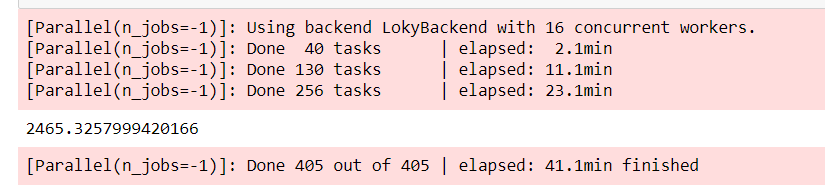

* Note : Since it took 41minute to finish the process, might not be a good idea to rerun

In [64]:
gs_model_5.best_score

{'rmse': 4.6013136585104375, 'mae': 3.4057897377720465}

In [65]:
gs_model_5.best_params

{'rmse': {'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.04},
 'mae': {'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.04}}

Intepretations & thoughts process
- Since `n_factors` show better result at **lower** range `10`, we will try compare with `5`
- Since `n_epochs` show better result at **lower** range `10`, we will try compare with `5`
- Since `lr_all` show better result at **lower** range `0.005`, we will try compare with `0.003 & 0.004`
- Since `reg_all` show better result at **higher** range `0.04`, we will try compare with `0.05 & 0.06`

In [67]:
## uncomment to re-rerun (~5.6 minutes required)

# param_grid_6 = {'n_factors':[5, 10], 'n_epochs': [5, 10], 
#                 'lr_all': [0.003, 0.004, 0.005], 'reg_all': [0.04, 0.05, 0.06]}

# gs_model_6 = GridSearchCV(SVDpp, param_grid = param_grid_6, n_jobs = -1, joblib_verbose = 5)
# gs_model_6.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  3.6min


5.597898391882579


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.6min finished


Result:
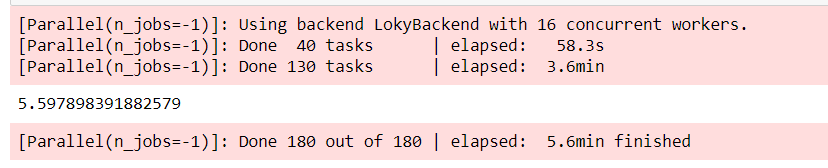

In [68]:
gs_model_6.best_score

{'rmse': 4.407410899254617, 'mae': 3.2950079420342036}

In [69]:
gs_model_6.best_params

{'rmse': {'n_factors': 10, 'n_epochs': 5, 'lr_all': 0.003, 'reg_all': 0.04},
 'mae': {'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.003, 'reg_all': 0.05}}

Intepretations & thoughts process
- Since `n_factors` doesn't show better result {rmse}, we will stop tuning it and set as `10`
- Since `n_epochs` show better result at **lower** range `5`, we will try compare with `3 & 4`
- Since `lr_all` show better result at **lower** range `0.003`, we will try compare with `0.001 & 0.002`
- Since `reg_all` doesn't show better result {rmse}, we will stop tuning it and set as `0.04`

In [70]:
param_grid_7 = {'n_factors':[10], 'n_epochs': [3, 4, 5], 
                'lr_all': [0.001, 0.002, 0.003], 'reg_all': [0.04]}

gs_model_7 = GridSearchCV(SVDpp, param_grid = param_grid_7, n_jobs = -1, joblib_verbose = 5)
gs_model_7.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  45 | elapsed:   33.4s remaining:   29.2s
[Parallel(n_jobs=-1)]: Done  34 out of  45 | elapsed:   50.9s remaining:   16.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   51.8s finished


In [71]:
gs_model_7.best_score

{'rmse': 4.401016558669431, 'mae': 3.3200587466279474}

In [72]:
gs_model_7.best_params

{'rmse': {'n_factors': 10, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.04},
 'mae': {'n_factors': 10, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.04}}

Intepretations & thoughts process
- Since `n_factors` doesn't show better result {rmse}, we will stop tuning it and set as `10`
- Since `n_epochs` doesn't show better result {rmse}, we will stop tuning it and set as `5`
- Since `lr_all` show better result at **middle** range `0.002`, we will set as `0.002`
- Since `reg_all` doesn't show better result {rmse}, we will stop tuning it and set as `0.04`

We will stop exploring apply the hyperparameter on trainset & testset

In [79]:
chosen_SVDpp = SVDpp(n_factors= 10, n_epochs=5, lr_all=0.002, reg_all=0.04)
chosen_SVDpp.fit(trainset)
predictions_SVDpp = chosen_SVDpp.test(testset)
accuracy_SVDpp = accuracy.rmse(predictions_SVDpp)
print(accuracy_SVDpp)

RMSE: 4.3962
4.396212009543398


`rmse` score for the chosen SVDpp model is __4.3962__.

### 4.2.3: `Slope One`

A simple yet accurate collaborative filtering algorithm.
> No hyperparameter for tuning

In [80]:
slopeone = SlopeOne()
slopeone.fit(trainset)
predictions_s1 = slopeone.test(testset)
accuracy_s1 = accuracy.rmse(predictions_s1)

<ipython-input-80-a7ed0cc085d0>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  slopeone.fit(trainset)


RMSE: 4.5380


`rmse` score for the chosen SlopeOne model is __4.5380__.

### 4.2.4: `CoClustering`

A collaborative filtering algorithm based on co-clustering.

- `n_cltr_u` : Number of user clusters. Default is 3.
- `n_cltr_i` :  Number of item clusters. Default is 3.
- `n_epochs` : Number of iteration of the optimization loop. Default is 20.


In [81]:
param_grid_8 = {'n_cltr_u':[2, 3, 4], 'n_cltr_i': [2, 3, 4], 'n_epochs': [10, 20, 30]}

gs_model_8 = GridSearchCV(CoClustering, param_grid = param_grid_8, n_jobs = -1, joblib_verbose = 5)
gs_model_8.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 132 out of 135 | elapsed:   39.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   39.9s finished


In [82]:
gs_model_8.best_score

{'rmse': 4.5920449729965425, 'mae': 3.4012237122189006}

In [83]:
gs_model_8.best_params

{'rmse': {'n_cltr_u': 2, 'n_cltr_i': 3, 'n_epochs': 30},
 'mae': {'n_cltr_u': 2, 'n_cltr_i': 3, 'n_epochs': 10}}

Intepretations & thoughts process
- Since `n_cltr_u` show better result at **lower** range `2`, we will try compare with `1`
- Since `n_cltr_i` show better result at **middle** range `3`, we will set as `3`
- Since `n_epochs` show better result at **higher** range `30`, we will try compare with `40 & 50`

In [84]:
param_grid_9 = {'n_cltr_u':[1, 2], 'n_cltr_i': [3], 'n_epochs': [30, 40, 50]}

gs_model_9 = GridSearchCV(CoClustering, param_grid = param_grid_9, n_jobs = -1, joblib_verbose = 5)
gs_model_9.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:    6.5s remaining:   26.3s
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:    9.0s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  20 out of  30 | elapsed:   10.1s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   13.6s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.3s finished


In [85]:
gs_model_9.best_score

{'rmse': 4.567399848705735, 'mae': 3.3907040873678262}

In [86]:
gs_model_9.best_params

{'rmse': {'n_cltr_u': 1, 'n_cltr_i': 3, 'n_epochs': 30},
 'mae': {'n_cltr_u': 1, 'n_cltr_i': 3, 'n_epochs': 30}}

Intepretations & thoughts process
- Since `n_cltr_u` show better result at **lowest** range `1`, we will set as `1`
- Since `n_cltr_i` doesn't show better result {rmse}, we will stop tuning it and set as `3`
- Since `n_epochs` doesn't show better result {rmse}, we will stop tuning it and set as `30`

In [87]:
coclustering = CoClustering(n_cltr_u = 1, n_cltr_i = 3, n_epochs = 30)
coclustering.fit(trainset)
predictions_cocl = coclustering.test(testset)
accuracy_cocl = accuracy.rmse(predictions_cocl)

<ipython-input-87-13b0258b4f57>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coclustering.fit(trainset)


RMSE: 4.5731


`rmse` score for the chosen CoClustering model is __4.5731__.

# Part 5: Model Performance

## 5.1: Model Performance metrics

In [103]:
# gives model report in dataframe
def model_report(model_type, model_name, predictions) :

    rmse = accuracy.rmse(predictions,verbose = False)
    mse  = accuracy.mse(predictions, verbose = False)
    mae  = accuracy.mae(predictions, verbose = False)
    fcp  = accuracy.fcp(predictions, verbose = False)
 
    df = pd.DataFrame({"Model Type"                  : [model_type],
                       "Model Name"                  : [model_name],
                       "Root Mean Squared Error"     : [rmse],
                       "Mean Squared Error"          : [mse],
                       "Mean Absolute Error"         : [mae],
                       "Fraction of Concordant Pairs": [fcp],
                      })
    return df

report_knn   = model_report('Memory-based', 'KNNWithMeans', predictions_knn)
report_SVD   = model_report('Model-based' , 'SVD', predictions_SVD)
report_SVDpp = model_report('Model-based' , 'SVD++', predictions_SVDpp)
report_s1    = model_report('Model-based' , 'SlopeOne', predictions_s1)
report_cocl  = model_report('Model-based' , 'CoClustering', predictions_cocl)

#concat all models
model_performances = pd.concat([report_knn,report_SVD,report_SVDpp,report_s1,report_cocl], axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index", axis =1)

model_performances.sort_values(by = 'Root Mean Squared Error', ascending = True)

,Model Type,Model Name,Root Mean Squared Error,Mean Squared Error,Mean Absolute Error,Fraction of Concordant Pairs
2,Model-based,SVD++,4.396212,19.326680,3.298829,0.562282
1,Model-based,SVD,4.436753,19.684773,3.347508,0.578480
3,Model-based,SlopeOne,4.537959,20.593073,3.361475,0.562952
0,Memory-based,KNNWithMeans,4.542634,20.635528,3.359994,0.579800
4,Model-based,CoClustering,4.573117,20.913403,3.395089,0.569040


As we can observed from above, `SVD++` has the lowest Root Mean Squared Error compared to the rest, </br>
However it also has the lowest `FCP` (Higher is better).

Also due to the facts that `SVD++` takes extremely large time to build the model compare to the 2nd Lowest `RSME` which is `SVD` </br>
Not to mentioned that `SVD` also has the 2nd highest `FCP` across all models

For this Jester Recommendation Engine, we can conclude 

* For Lowest RMSE --> `SVD++`
* For Highest FCP --> `KNNWithMeans`
* For Overall Performance --> `SVD `

Fraction of Concordant Pairs (FCP)
> If product A receives a higher rating than product B from a user and the model predicts the same, A and B are a concordant pair, otherwise a discordant pair. FCP is simply the fraction of concordant pairs among all the pairs (sum over all users).

# Part 6: Recommendation Engine

Get the k nearest neighbors of an item

In [172]:
input_jokes = 'jokes_82'

# Read the mappings raw id <-> jokes name
name_to_rid = {}
rid_to_name = {}

for i in trainsetfull_raw_iids:
    name_to_rid[i] = trainsetfull_iids[trainsetfull_raw_iids.index(i)]
    
for i in trainsetfull_iids:
    rid_to_name[i] = trainsetfull_raw_iids[trainsetfull_iids.index(i)]
    
# based on above performance results
chosen_k = 40
chosen_sim_option = sim_pearson

# First, train the algortihm to compute the similarities between items
algo = KNNWithMeans(k = chosen_k, sim_options = chosen_sim_option)
algo.fit(trainsetfull)

# Retrieve inner id of jokes_82
input_jokes_raw_id = name_to_rid[input_jokes]

# Retrieve the nearest neighbors of jokes_82 using inner id.
input_jokes_neighbors = algo.get_neighbors(input_jokes_raw_id, k=10)

# Convert inner ids of the neighbors into names.
input_jokes_neighbors = (algo.trainset.to_raw_iid(inner_id) for inner_id in input_jokes_neighbors)

print('\n\n')
print('input_jokes:  ' + df_jokes.loc[input_jokes][0])
print('\n\n')

print('The 10 nearest neighbors of input_jokes are:')
for count, jokes in enumerate(input_jokes_neighbors):
    print( str(count+1) + ':  '     + df_jokes.loc[jokes][0] + '\n')

Computing the pearson similarity matrix...
Done computing similarity matrix.



input_jokes:  Q: How do you keep a computer programmer in the  shower all day long?  A: Give them a shampoo with a label that says "rinse, lather, repeat".



The 10 nearest neighbors of input_jokes are:
1:  What is the rallying cry of the International Dyslexic Pride movement? Dyslexics Untie!

2:  A couple has been married for 75 years. For the husband's 95th birthday, his wife decides to surprise him by hiring a prostitute. That day, the doorbell rings. The husband uses his walker to get to the door and opens it.  A 21-year-old in a latex outfit smiles and says, "Hi, I here to give you super sex!"  The old man says, "I'll take the soup."

3:  What do you call an American in the finals of the world cup?  "Hey Beer Man!"

4:  An artist asked the gallery owner if there had been any interest in his paintings currently on display. "I've got good news and bad news," the owner replied. "The good news is that a 